### 1. Import the necessary libraries

In [1]:
!pip install pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.4 MB/s eta 0:00:00


In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from joblib import dump,load
from sklearn.decomposition import PCA
from pyvi import ViTokenizer
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

### 2 Data preprocessing

Read csv

In [2]:
def ReadData(path):
    df=pd.read_csv(path,encoding='utf-8')
    return df['corpus'], df['label']

In [3]:
X_train,y_train = ReadData("/content/train_df.csv")
X_test,y_test=ReadData("/content/test_df.csv")

In [4]:
print(X_test[128])

quan_sát bên ngoài thấy chắc_chắn chưa dùng nên chưa nhận_định được chất_lượng tuy_nhiên hàng mua của tki thì yên_tâm hơn hết


In [5]:
print(f"X_Train size:{X_train.shape}")
print(f"y_train size {y_train.shape}")

X_Train size:(11525,)
y_train size (11525,)


word separation

In [6]:
def wordseparation(comment):
   tokens = comment.split()
   return tokens

In [7]:
X_train = X_train.fillna('')  # thay NaN bằng chuỗi rỗng
X_test = X_test.fillna('')

Use tfidf to represent words


In [8]:
vectorizer = TfidfVectorizer(tokenizer=wordseparation, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [9]:
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(11525, 76930)
(2882, 76930)


In [10]:
print(X_train_tfidf[0])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 13 stored elements and shape (1, 76930)>
  Coords	Values
  (0, 21876)	0.2636824329649041
  (0, 7340)	0.36127145058969135
  (0, 34251)	0.11354468713036339
  (0, 58007)	0.14523510671189757
  (0, 2155)	0.2715859800364774
  (0, 8624)	0.11462887162922282
  (0, 21924)	0.36127145058969135
  (0, 7341)	0.36127145058969135
  (0, 34357)	0.22059599822637033
  (0, 22276)	0.2653378655500729
  (0, 58014)	0.36127145058969135
  (0, 2157)	0.3461063474986156
  (0, 21934)	0.22059599822637033


Visualize a sentence

In [11]:
feature_names = vectorizer.get_feature_names_out()  ## lấy danh sách các từ trong từ điển
first_doc_tfidf = X_train_tfidf[0].tocoo()
words_tfidf = {feature_names[word]: tfidf for word, tfidf in zip(first_doc_tfidf.col, first_doc_tfidf.data)}

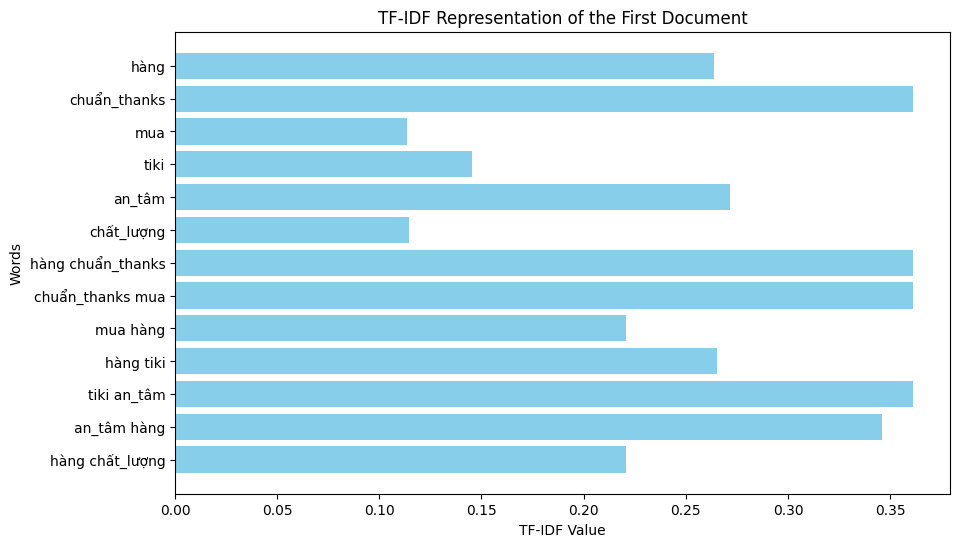

In [12]:
words = list(words_tfidf.keys())
values = list(words_tfidf.values())
plt.figure(figsize=(10, 6))
plt.barh(words, values, color='skyblue')
plt.xlabel('TF-IDF Value')
plt.ylabel('Words')
plt.title('TF-IDF Representation of the First Document')
plt.gca().invert_yaxis()
plt.show()

In [13]:
print(X_train_tfidf[0])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 13 stored elements and shape (1, 76930)>
  Coords	Values
  (0, 21876)	0.2636824329649041
  (0, 7340)	0.36127145058969135
  (0, 34251)	0.11354468713036339
  (0, 58007)	0.14523510671189757
  (0, 2155)	0.2715859800364774
  (0, 8624)	0.11462887162922282
  (0, 21924)	0.36127145058969135
  (0, 7341)	0.36127145058969135
  (0, 34357)	0.22059599822637033
  (0, 22276)	0.2653378655500729
  (0, 58014)	0.36127145058969135
  (0, 2157)	0.3461063474986156
  (0, 21934)	0.22059599822637033


### 3.Built Model Random Forest


#### 3.1 Use K-Fold Cross-validation technique to find the best set of parameters

In [14]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

In [15]:
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,       # 5-fold cross validation
                           n_jobs=-1,  # dùng tất cả CPU
                           scoring='f1_macro')

# Tìm kiếm tham số
grid_search.fit(X_train_tfidf, y_train)

# Kết quả tốt nhất
print("Tham số tốt nhất:", grid_search.best_params_)
print("F1 score tốt nhất:", grid_search.best_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/util

Tham số tốt nhất: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
F1 score tốt nhất: 0.46917061121657955


#### 3.2 Model Random Forest

In [16]:
model_rf = RandomForestClassifier(
    n_estimators=50,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)

In [17]:
model_rf.fit(X_train_tfidf,y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [18]:
dump(model_rf, 'rf_model_sentiment.pkl')

['rf_model_sentiment.pkl']

In [19]:
model_knn_loaded=load('rf_model_sentiment.pkl')

#### 3.4. Evaluating

In [20]:
result_predict=model_knn_loaded.predict(X_test_tfidf)

In [21]:
accuracy=accuracy_score(y_test,result_predict)
print(f'Accuracy: {accuracy:.4f}')
precision=precision_score(y_test,result_predict,average='weighted')
print(f"Precision: {precision:.4f}")
recall=recall_score(y_test,result_predict,average='weighted')
print(f"Recall: {recall:.4f}")
f1score=f1_score(y_test,result_predict,average='weighted')
print(f"F1-score: {f1score}")

Accuracy: 0.8567
Precision: 0.8039
Recall: 0.8567
F1-score: 0.8201370798202341


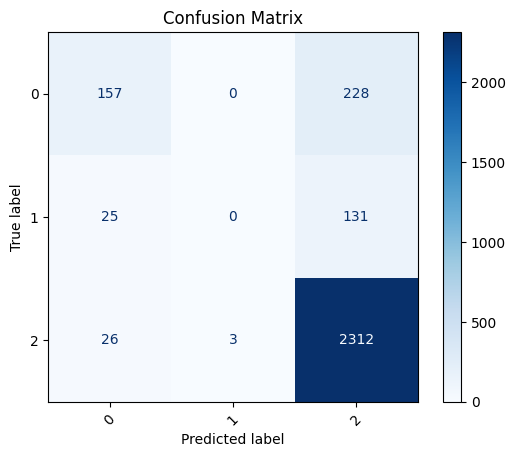

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(y_test, result_predict)

# Hiển thị ma trận nhầm lẫn dưới dạng biểu đồ
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_knn_loaded.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)

# Thêm tiêu đề và hiển thị
plt.title("Confusion Matrix")
plt.show()

In [23]:
accuracy=accuracy_score(y_test,result_predict)
print(f'Accuracy: {accuracy:.4f}')
precision=precision_score(y_test,result_predict,average='macro')
print(f"Precision: {precision:.4f}")
recall=recall_score(y_test,result_predict,average='macro')
print(f"Recall: {recall:.4f}")
f1score=f1_score(y_test,result_predict,average='weighted')
print(f"F1-score: {f1score}")

Accuracy: 0.8567
Precision: 0.5401
Recall: 0.4651
F1-score: 0.8201370798202341
